In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

In [54]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instances (m): 1,000
- Squence length (per instance): 30 sec
- Labels: 10 (Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparing the dataset. 


### Steps
1. Create the dataset. Feature Engineering
2. Fit the CNN to the dataset
3. Evaluate the performance

### Creating the dataset
Based on the different resources I am finding online (Kaggle and some blog posts), it seems like the way to go is to extract meaningful features from the data, shape them so that they share dimensions and build a tensor out of them.
The most interesting feature was the Mel-Spectogram

## 1. Setup, Data, Feature Engineering

In [3]:
# Setup: path, one-hot vector for the labels
# ----------------

path = '../data/genres/'
labels = [f.name for f in os.scandir(path) if f.is_dir()]

# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            n_files += 1
print(f'n_files: {n_files}')

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
pop [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
metal [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
disco [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
blues [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
classical [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
rock [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
country [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 1000


In [4]:
# Global variables
# ----------------

H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform


In [5]:
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr

def listen_sample(sample, sr=44100):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))


def augment_sample(sample, sr):
    """
    Data augmentation. To prevent overfitting
    Techniques used: pitch shist, time stretch, add noise

    Args:
        sample: usually output of lb.load()
        sr = sampling rate. output from lb.load()
        
    Returns:
        list with each augmented sample as an item of the list
    """
    augmented_samples = list()
    #. 1. Split the sample into smaller samples
    samples = np.array_split(sample, N_SLICES)
    
    for sample_ in samples:
        # 2. Add the original sample
        augmented_samples.append(sample_)
        # 3. Change pitch
        for n_steps in [4,6]:
            augmented_samples.append(lb.effects.pitch_shift(sample_, sr,n_steps))

        # 4. Time Stretch
        for rate in [0.5, 2.0]:
            augmented_samples.append(lb.effects.time_stretch(sample_, rate))

        # 5. White Noise
        wn = np.random.randn(len(sample_))
        augmented_samples.append(sample_ + 0.005*wn)
    
    return augmented_samples

def get_input_length(path, folders):
    """
    Get the input length from the first file
    """
    folder = folders[0]
    files = os.listdir(path+folder)
    input_length = 0
    for file in files:
        if file.split('.')[-1] == 'wav':
            sample, sr = read_sample(path+folder+'/'+file)
            input_length = len(sample) // N_SLICES
            break
        
    
    return input_length


def get_n_frames(sample, sr):
    mel = lb.feature.melspectrogram(sample, sr)
#     print(mel.shape)
    return mel.shape[1]
    
    
def read_raw_data(path, folders):
    """
    Read the data from disk and save it in two numpy arrays. 
    Run only once, and then run create_dataset for computing 
    the different features.
    
    Args:
        path: path to where the folders with the audio data is
        folders: list of folders. in this case is the same as the labels
        
    Returns: 
        x_raw: samples plus augmented samples. 
         shape: (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        y_raw: y tensor of the samples and augmented samples
         shape: (N_FILES*AUG_FEATURES, 10) one-hot encoded
    
    """
    input_length = get_input_length(path, folders)
    
    x_raw = np.zeros((M, input_length))
    y_raw = np.zeros((M, 10))
    print(x_raw.shape, y_raw.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+folder)
        for file in files:
            
            # make sure the file is a .wav file
            if file.split('.')[-1] == 'wav':
                sample, sr = read_sample(path+folder+'/'+file)
                aug_samples = augment_sample(sample, sr)
                for sample_ in aug_samples: 
                    # padding or shorten sample
                    if len(sample_) > input_length:
                        sample_ = sample_[:input_length]
                    else:
                        sample_ = np.pad(sample_, (0, max(0, input_length - len(sample_))))
                    x_raw[i,:] = sample_
                    y_raw[i,:] = oh_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return x_raw, y_raw, sr
    
def create_dataset(x_raw, sr):
    """
    Args:
        x_raw: Tensor with shape (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        sr: The sr used across the samples. same for all
    
    Returns: 
        X: Tensor(n_files, 128, frames, N_FEATURES). With the features
        already encoded
        
    """
    n_frames = get_n_frames(x_raw[0,:], sr)
    X = np.zeros((M, 128, n_frames, N_FEATURES))

    for i in range(M):
        sample = x_raw[i,:]
        mel = lb.feature.melspectrogram(sample, sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)
        X[i,:,:,0] = norm_spect

                
    return X

In [6]:
# Reading raw data from files
# -------------
# saving it into disk in case we need to load it

x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)
# np.save('../data/x_raw_3_slice', x_raw)
# np.save('../data/y_raw_3_slice', y_raw)

(18000, 220501) (18000, 10)
Reading pop
Reading metal
Reading disco
Reading blues
Reading reggae
Reading classical
Reading rock
Reading hiphop
Reading country
Reading jazz
Samples read:  18000
(18000, 220501) (18000, 10)


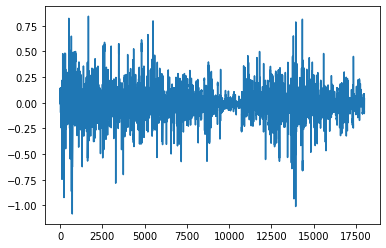

In [7]:
plt.plot(x_raw[:,0])

In [7]:
# Run only if we are loading the data

x_raw = np.load('../data/x_raw_3_slice.npy')
y_raw = np.load('../data/y_raw_3_slice.npy')
_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [8]:
# Creating the tensor with the features
# -----------

X = create_dataset(x_raw, sr)
Y = np.copy(y_raw)
print(X.shape)
print(Y.shape)

(18000, 128, 431, 1)
(18000, 10)


In [9]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [10]:
# Train, validation, test split
# ------------
# 80% for training, 10% for validation and 10% for testing

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {x_train.shape} {y_train.shape}')
print(f'Valid: {x_val.shape}   {y_val.shape}')
print(f'Test:  {x_test.shape}  {y_test.shape}')


Train: (14400, 128, 431, 1) (14400, 10)
Valid: (1800, 128, 431, 1)   (1800, 10)
Test:  (1800, 128, 431, 1)  (1800, 10)


## 2. Modeling
- CNN-64
- LeNet-5

### LeNet-5

In [30]:
# LeNet-5
# -----
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 

x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

In [36]:
lenet = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
lenet.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
lenet.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 431, 1)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 126, 429, 8)       80        
_________________________________________________________________
average_pooling2d_2 (Average (None, 63, 214, 8)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 214, 8)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 212, 16)       1168      
_________________________________________________________________
average_pooling2d_3 (Average (None, 30, 106, 16)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 106, 16)       0   

In [37]:
epochs = 20

history_lenet = lenet.fit(x=x_train, 
                          y=y_train,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          shuffle=True)

Epoch 1/20
450/450 [==============================] - 111s 245ms/step - loss: 1.8968 - accuracy: 0.3035 - val_loss: 1.6332 - val_accuracy: 0.4133
Epoch 2/20
450/450 [==============================] - 101s 224ms/step - loss: 1.4993 - accuracy: 0.4564 - val_loss: 1.3039 - val_accuracy: 0.5500
Epoch 3/20
450/450 [==============================] - 101s 225ms/step - loss: 1.2724 - accuracy: 0.5460 - val_loss: 1.1724 - val_accuracy: 0.5828
Epoch 4/20
450/450 [==============================] - 101s 225ms/step - loss: 1.0858 - accuracy: 0.6142 - val_loss: 1.0174 - val_accuracy: 0.6500
Epoch 5/20
450/450 [==============================] - 102s 226ms/step - loss: 0.9215 - accuracy: 0.6750 - val_loss: 0.8992 - val_accuracy: 0.6933
Epoch 6/20
450/450 [==============================] - 101s 225ms/step - loss: 0.8144 - accuracy: 0.7126 - val_loss: 0.8685 - val_accuracy: 0.7144
Epoch 7/20
450/450 [==============================] - 101s 225ms/step - loss: 0.7196 - accuracy: 0.7465 - val_loss: 0.8422 -

In [45]:
lenet.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 4s 66ms/step - loss: 1.0697 - accuracy: 0.7456


[1.069667100906372, 0.745555579662323]

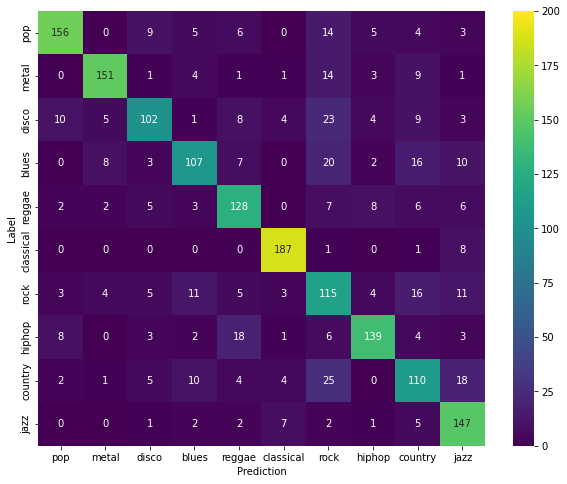

In [43]:
# HeatMap LeNet 

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(lenet.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("../png/lenet_confmatrix.png", dpi=150)
plt.show()

In [82]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

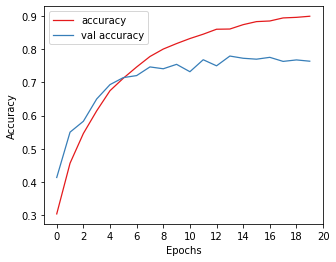

In [84]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), history_lenet.history['accuracy'], label='accuracy', lw=1.25)
ax.plot(range(epochs), history_lenet.history['val_accuracy'], label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,2)])
ax.legend()
plt.savefig("../png/lenet_acc_epochs.png", dpi=150)

plt.show()

### CNN-64

In [28]:
# CNN-64 Resizing + FC
# --------

n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [33]:
# Original
# ---------

n_filters = 64
inputs = keras.Input(shape=input_shape) 
x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [15]:
# Building the model. Compiling
# --------------
# Loss: Categorical Cross Entropy, since we have one-hot vectors. 

model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 431, 1)]     0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0   

In [16]:
epochs = 20

history = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
450/450 [==============================] - 199s 439ms/step - loss: 1.9575 - accuracy: 0.2879 - val_loss: 1.5915 - val_accuracy: 0.4517
Epoch 2/20
450/450 [==============================] - 185s 412ms/step - loss: 1.5291 - accuracy: 0.4501 - val_loss: 1.4834 - val_accuracy: 0.4894
Epoch 3/20
450/450 [==============================] - 184s 408ms/step - loss: 1.3348 - accuracy: 0.5252 - val_loss: 1.1925 - val_accuracy: 0.5883
Epoch 4/20
450/450 [==============================] - 184s 408ms/step - loss: 1.2121 - accuracy: 0.5757 - val_loss: 1.0906 - val_accuracy: 0.6333
Epoch 5/20
450/450 [==============================] - 192s 427ms/step - loss: 1.1081 - accuracy: 0.6046 - val_loss: 0.9628 - val_accuracy: 0.6622
Epoch 6/20
450/450 [==============================] - 198s 439ms/step - loss: 1.0105 - accuracy: 0.6424 - val_loss: 0.8562 - val_accuracy: 0.7033
Epoch 7/20
450/450 [==============================] - 199s 441ms/step - loss: 0.9339 - accuracy: 0.6614 - val_loss: 0.8464 -

In [33]:
history2 = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=20,
                    epochs=50,
                    shuffle=True)

Epoch 21/50
450/450 [==============================] - 236s 524ms/step - loss: 0.4612 - accuracy: 0.8306 - val_loss: 0.5855 - val_accuracy: 0.8139
Epoch 22/50
450/450 [==============================] - 191s 425ms/step - loss: 0.4392 - accuracy: 0.8389 - val_loss: 0.5825 - val_accuracy: 0.8067
Epoch 23/50
450/450 [==============================] - 182s 404ms/step - loss: 0.4205 - accuracy: 0.8467 - val_loss: 0.6201 - val_accuracy: 0.8094
Epoch 24/50
450/450 [==============================] - 180s 400ms/step - loss: 0.4138 - accuracy: 0.8504 - val_loss: 0.5520 - val_accuracy: 0.8411
Epoch 25/50
450/450 [==============================] - 179s 398ms/step - loss: 0.3917 - accuracy: 0.8593 - val_loss: 0.6241 - val_accuracy: 0.8122
Epoch 26/50
450/450 [==============================] - 179s 397ms/step - loss: 0.3837 - accuracy: 0.8609 - val_loss: 0.6205 - val_accuracy: 0.8250
Epoch 27/50
450/450 [==============================] - 180s 400ms/step - loss: 0.3748 - accuracy: 0.8620 - val_loss: 0

In [93]:
history3 = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    initial_epoch=50,
                    epochs=100,
                    shuffle=True)

Epoch 51/100
450/450 [==============================] - 221s 489ms/step - loss: 0.2459 - accuracy: 0.9124 - val_loss: 0.5377 - val_accuracy: 0.8617
Epoch 52/100
450/450 [==============================] - 184s 408ms/step - loss: 0.2428 - accuracy: 0.9131 - val_loss: 0.5973 - val_accuracy: 0.8617
Epoch 53/100
450/450 [==============================] - 181s 401ms/step - loss: 0.2368 - accuracy: 0.9147 - val_loss: 0.5645 - val_accuracy: 0.8583
Epoch 54/100
450/450 [==============================] - 178s 395ms/step - loss: 0.2273 - accuracy: 0.9205 - val_loss: 0.5349 - val_accuracy: 0.8617
Epoch 55/100
450/450 [==============================] - 178s 395ms/step - loss: 0.2385 - accuracy: 0.9174 - val_loss: 0.5395 - val_accuracy: 0.8572
Epoch 56/100
450/450 [==============================] - 178s 394ms/step - loss: 0.2241 - accuracy: 0.9199 - val_loss: 0.5114 - val_accuracy: 0.8639
Epoch 57/100
450/450 [==============================] - 177s 394ms/step - loss: 0.2199 - accuracy: 0.9224 - val_

In [94]:
model.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 5s 82ms/step - loss: 0.6635 - accuracy: 0.8528


[0.6635146737098694, 0.8527777791023254]

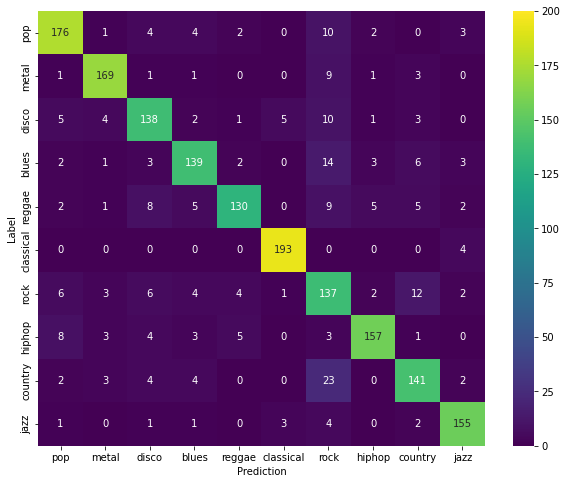

In [95]:
# HeatMap CNN64 filtered

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("../png/cnn64_confmatrix.png", dpi=150)
plt.show()

In [27]:
model.save('../models/model1')

INFO:tensorflow:Assets written to: ../models/model1/assets


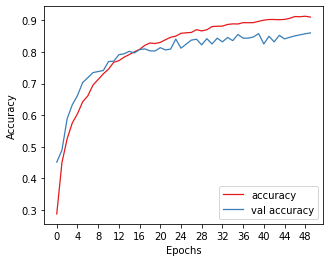

In [92]:
epochs = 50
hist_acc = history.history['accuracy'] + history2.history['accuracy']
hist_val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("../png/cnn64_acc_epochs.png", dpi=150)

plt.show()